# Variación del tamaño de los picos de *Geospiza scandens*

En este notebook se analiza la variación de la longitud y la altura picos de las aves durante los años 1943 a 2012, y se realiza una prueba de hipótesis estadística para afirmar si efectivamente ocurrió una variación o se trata de una coincidencia en los datos. 

<p align="center">
  <img width="700" src="https://www.notion.so/image/https%3A%2F%2Fs3-us-west-2.amazonaws.com%2Fsecure.notion-static.com%2F81d21818-0ee3-402d-9f62-aaeb292876df%2Fpicos.png?table=block&id=f5396e96-0f64-4089-a328-e0c697b4bc40&width=2130&userId=5d54f20c-b387-4e7e-b2a5-d88e235ada88&cache=v2">
</p>

In [1]:
import numpy as np # 
import pandas as pd # 
import matplotlib.pyplot as plt 
import seaborn as sns 

np.random.seed(42)

%matplotlib inline

sns.set() 

# Importar las funciones matematicas definidas para el analisis
%run funciones-matematicas.ipynb

# Ajustar tamaño de las figuras en matplotlib
plt.rcParams['figure.figsize'] = [10, 8]

In [2]:
# Lectura y preparación de los datos
data_1975 = pd.read_csv('./datasets/finch_beaks_1975.csv')
data_2012 = pd.read_csv('./datasets/finch_beaks_2012.csv')

# Verificar nombres de columnas
print(data_1975.columns)
print(data_2012.columns)

Index(['band', 'species', 'Beak length, mm', 'Beak depth, mm'], dtype='object')
Index(['band', 'species', 'blength', 'bdepth'], dtype='object')


In [3]:
# Igualar nombres de columnas
data_2012.columns = data_1975.columns

In [4]:
# Añadir años
data_1975['year'] = 1975
data_2012['year'] = 2012

In [5]:
data = pd.concat([data_1975, data_2012], axis=0)

In [6]:
# Verificar si existen datos nulos
data.isnull().sum()

band               0
species            0
Beak length, mm    0
Beak depth, mm     0
year               0
dtype: int64

In [9]:
# exportar dataframe limpio
data.to_csv('./datasets/data_finch_beaks.csv', index=False)

## Análisis exploratorio 

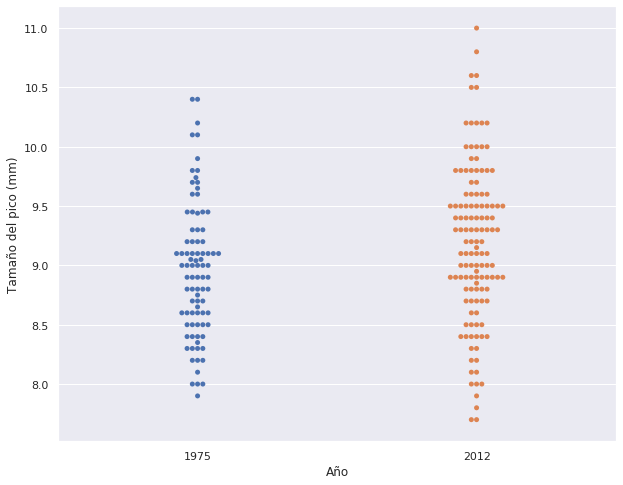

In [8]:
# Geospiza scandens

scandens = data[data['species']== 'scandens']

_ = sns.swarmplot(x='year', y='Beak depth, mm', data=scandens)
_ = plt.ylabel('Tamaño del pico (mm)')
_ = plt.xlabel('Año')
plt.show()

Esta gráfica da la impresión de que el tamaño del pico promedio aumento ligeramente en el año 2012, sin embargo, para tener una visualización más precisa, se utilizará la función de distribución acumulativa empírica (ecdf).

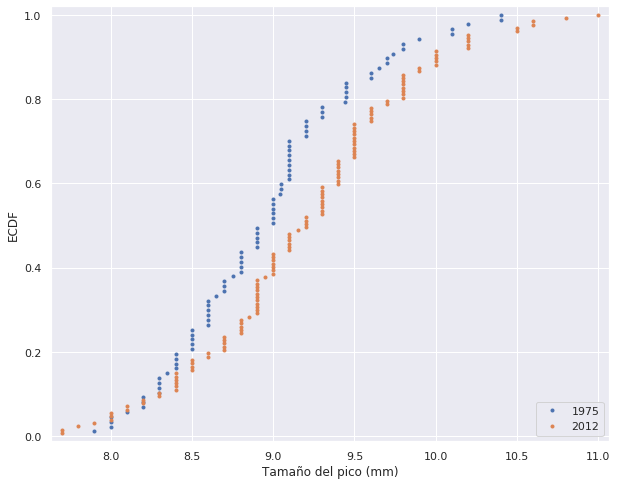

In [9]:
# Seleccionar del dataframe scandens los valores del tamaño de los picos (bd) en 1975 y 2012
bd_1975 = scandens[scandens['year']== 1975]['Beak depth, mm']
bd_2012 = scandens[scandens['year']== 2012]['Beak depth, mm']

x_1975, y_1975 = ecdf(bd_1975)
x_2012, y_2012 = ecdf(bd_2012)

# Graficar las ECDF
_ = plt.plot(x_1975, y_1975, marker='.', linestyle='none')
_ = plt.plot(x_2012, y_2012, marker='.', linestyle='none')

# Ajustes del margen
plt.margins(0.02)

# Ajustes de los ejes y leyendas
_ = plt.xlabel('Tamaño del pico (mm)')
_ = plt.ylabel('ECDF')
_ = plt.legend(('1975', '2012'), loc='lower right')

# Mostrar 
plt.show()

Las diferencias son mucho más claras en la ECDF, el promedio es mayor en los datos de 2012 y la varianza también parece aumentar, por lo que se puede concluir que efectivamente los tamaños de los picos han aumentado.

## Estimación de parámetros: ¿Qué tan grande es el tamaño del pico en promedio?

A continuación se estimará la diferencia promedio de los picos entre 2012 y 1975. Se utilizará la técnica de remuestreo Bootstrapping para presentar los resultados dentro del 95% del intervalo de confianza.

In [10]:
# Calcular la diferencia de las medias muestrales
mean_diff = np.mean(bd_2012) - np.mean(bd_1975)

# Obtener los bootstrap replicates del promedio 
bs_replicates_1975 = draw_bs_reps(bd_1975, np.mean, size=10000)
bs_replicates_2012 = draw_bs_reps(bd_2012, np.mean, size=10000)

# Calcular la diferencia de los bootstrap replicates 
bs_diff_replicates = bs_replicates_2012 - bs_replicates_1975

# Calcular el 95% del intervalo de confianza
conf_int = np.percentile(bs_diff_replicates, [2.5, 97.5])

# Print the results
print('Diferencia de promedios:', mean_diff, 'mm')
print('95% intervalo de confianza =', conf_int, 'mm')

Diferencia de promedios: 0.2262204724409429 mm
95% intervalo de confianza = [0.05633521 0.39190544] mm


El intervalo de confianza nos dice que en el caso de que se pudieran reunir nuevas muestras, existe un 95% de probabilidad de que el valor real de la diferencia de los promedios se encuentre entre 0,056 y 0,392 mm.

## Test de hipótesis

El gráfico de la ECDF y la determinación del intervalo de confianza dejan bastante claro que los picos de G. *scandens* en Daphne Major han aumentado su tamaño. Pero, ¿es posible que este efecto se deba sólo al azar? Para evaluar esta posibilidad, se establecerá la hipótesis de que los tamaños de los picos promedio son iguales en 1975 y 2012, y se calculará la probabilidad de obtener la diferencia observada de 0.226 mm. 

- `Hipótesis nula (H0):` El tamaño de los picos son iguales en 1975 y 2012. La diferencia observada fue producto del azar. 

- `Test estadístico`: Diferencia entre los promedios.

- `P-value`: La probabilidad de obtener valores iguales o mayores a la diferencia de promedios observada. 

In [12]:
# Calcular el promedio del dataset combinado
combined_mean = np.mean(np.concatenate((bd_1975, bd_2012)))

# Desplazar las muestras para hacer que tengan igual promedio
bd_1975_shifted = bd_1975 - np.mean(bd_1975) + combined_mean
bd_2012_shifted = bd_2012 - np.mean(bd_2012) + combined_mean

# Obtener bootstrap replicates
bs_replicates_1975 = draw_bs_reps(bd_1975_shifted, np.mean, 10000)
bs_replicates_2012 = draw_bs_reps(bd_2012_shifted, np.mean, 10000)

# Calcular la diferencia entre los bootstrap replicates de 2012 y 1975
bs_diff_replicates = bs_replicates_2012 - bs_replicates_1975

# Calcular p value
p = np.sum(bs_diff_replicates >= mean_diff) / len(bs_diff_replicates)

print('p =', p)

p = 0.0035


Este bajo valor de p-value conduce a rechazar la hipótesis nula inicial, ya que esto significa que la probabilidad de que la diferencia de promedios observada sea producto del azar es de 3.5%, por lo tanto se confirma que el tamaño del pico aumentó con el tiempo.